In [1]:
! git clone https://github.com/mrinath123/ML4SCI_Deeplense.git
! pip install -q timm

Cloning into 'ML4SCI_Deeplense'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 42 (delta 10), reused 23 (delta 4), pack-reused 0
Unpacking objects: 100% (42/42), 1.30 MiB | 3.87 MiB/s, done.


In [2]:
!conda install -q -y gdown

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.7.1             |     pyhd8ed1ab_0          12 KB  conda-forge
    gdown-4.4.0                |     pyhd8ed1ab_0          16 KB  conda-forge
    openssl-1.1.1q             |       h166bdaf_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.7.1-pyhd8ed1ab_0
  gdown              conda-forge/noarch::gdown-4.4.0-pyhd8ed1ab_0

The following packages will be UPDATED:

  openssl                                 1.1.1o-h166bdaf_0 --> 1.1.1q-h166bdaf_0


Preparing transaction: ...working... done
Verif

In [3]:
import timm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm.notebook import tqdm
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import math
import random
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim
from transformers import get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')
from sklearn import  model_selection

In [4]:
sys.path.insert(0, './ML4SCI_Deeplense/Lensing_DomainAdaptation')

In [5]:
from models import *
from pretraining import *
from utils import *
from dataset import *

# Downloading the data for Pre-training

In [6]:
!gdown http://drive.google.com/uc?id=1cRjseeUQhab5TRRb0NDmFxjGdsd0Fwo0
!gdown http://drive.google.com/uc?id=1MJ-k5xWiww6IFauu7oqqD6mzKfJiMo3r

Downloading...
From: http://drive.google.com/uc?id=1cRjseeUQhab5TRRb0NDmFxjGdsd0Fwo0
To: /kaggle/working/hsc2.zip
100%|█████████████████████████████████████████| 621M/621M [00:03<00:00, 159MB/s]
Downloading...
From: http://drive.google.com/uc?id=1MJ-k5xWiww6IFauu7oqqD6mzKfJiMo3r
To: /kaggle/working/hsc_lens_smooth.zip
100%|█████████████████████████████████████████| 638M/638M [00:02<00:00, 230MB/s]


# Preparing the data

In [7]:
!unzip -q hsc2.zip
!unzip -q hsc_lens_smooth.zip
cls1 = os.listdir("./hsc") # class 1 (non-lensing)
cls2 = os.listdir("./hsc_lens_smooth") # class 2 (lensing)
cls1 = ['./hsc/' + i for  i in cls1 ]
cls2 = ['./hsc_lens_smooth/' + i for  i in cls2 ]

In [8]:
X_train, X_val , X_test = prep_data(cls1 , cls2) # first argument is for non-lensing images
X_train.shape , X_val.shape , X_test.shape

((40638, 2), (13546, 2), (6021, 2))

In [9]:
# setting the seed for reprodecubility
set_seed(42)

In [10]:
# device o where trainiung and testing will be done
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Augmentations

In [11]:
image_size = 64
train_aug = A.Compose(
    [  
        A.RandomCrop(32,32,p=0.5),
         A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)
val_aug = A.Compose(
    [ 
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)

# Defining Dataloaders for Training

In [12]:
train_data= Len(X_train,train_aug)
val_data= Len(X_val ,val_aug)


train_loader = DataLoader(train_data,
                         shuffle=True,
                    num_workers=4,
                    batch_size=64,drop_last = True,pin_memory=True)

valid_loader = DataLoader(val_data,
                         shuffle=False,
                    num_workers=4,
                    batch_size=64*2,drop_last = False ,pin_memory=True)

# Declaring the models

In [13]:
encoder = Encoder(pretrained = True)
classifier = Classifier()
encoder = encoder.to(device)
classifier = classifier.to(device)


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2_ns-00306e48.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b2_ns-00306e48.pth


In [14]:
# path where model weights will get saved
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [15]:
supervised = PreTraining_Train(encoder,classifier,device,train_loader , valid_loader, OUTPUT_DIR,plot_metrics = True)

# Training

  0%|          | 0/634 [00:00<?, ?it/s]

For epoch 1/3
average train_loss 0.3751507678395284
average train_auc 0.8926439129049465
average train_acc 0.8452533517350158


  0%|          | 0/106 [00:00<?, ?it/s]

avarage val_loss 0.04556680655236982
avarage val_auc 0.9987794453944627
avarage val_acc 0.9873025247305478


  0%|          | 0/634 [00:00<?, ?it/s]

For epoch 2/3
average train_loss 0.06214057833208976
average train_auc 0.9980917242633641
average train_acc 0.9787312697160884


  0%|          | 0/106 [00:00<?, ?it/s]

avarage val_loss 0.017975471092083598
avarage val_auc 0.9996536362341258
avarage val_acc 0.9950538904473646


  0%|          | 0/634 [00:00<?, ?it/s]

For epoch 3/3
average train_loss 0.040656127714646
average train_auc 0.9992725672945132
average train_acc 0.985410094637224


  0%|          | 0/106 [00:00<?, ?it/s]

avarage val_loss 0.014741744438952742
avarage val_auc 0.9997379341524479
avarage val_acc 0.9951277129780008


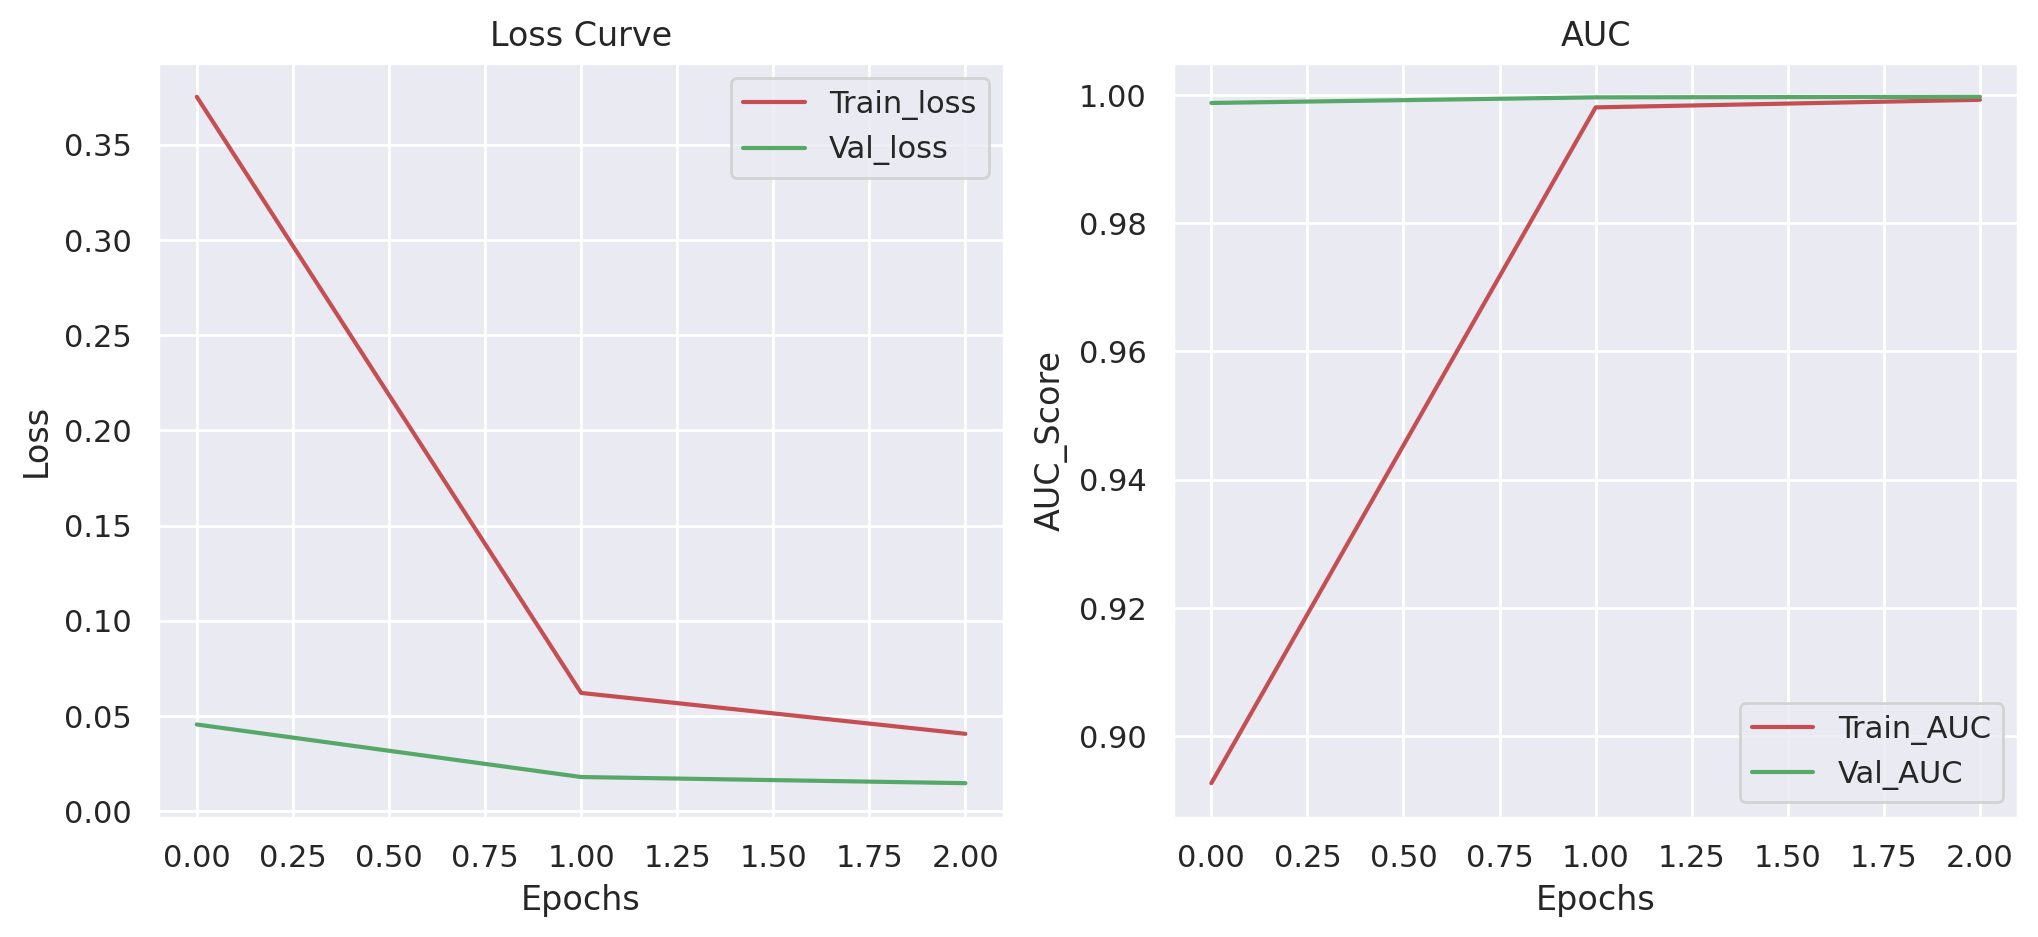

In [16]:
supervised.train()

# Testing

In [17]:
test_data = Len(X_test ,val_aug)
test_loader = DataLoader(test_data, shuffle=False,
                        num_workers=4,
                        batch_size=100,drop_last = False)

In [21]:
# use the best model weights path from the OUTPUT directory
best_encoder_path = './ Encoder_val_auc 0.9997379341524479.pth'
best_classifier_path = './ Classiifier_val_auc 0.9997379341524479.pth'

In [22]:
supervised_test = PreTraining_Test(encoder,classifier,device,test_loader , best_encoder_path, best_classifier_path)

  0%|          | 0/61 [00:00<?, ?it/s]

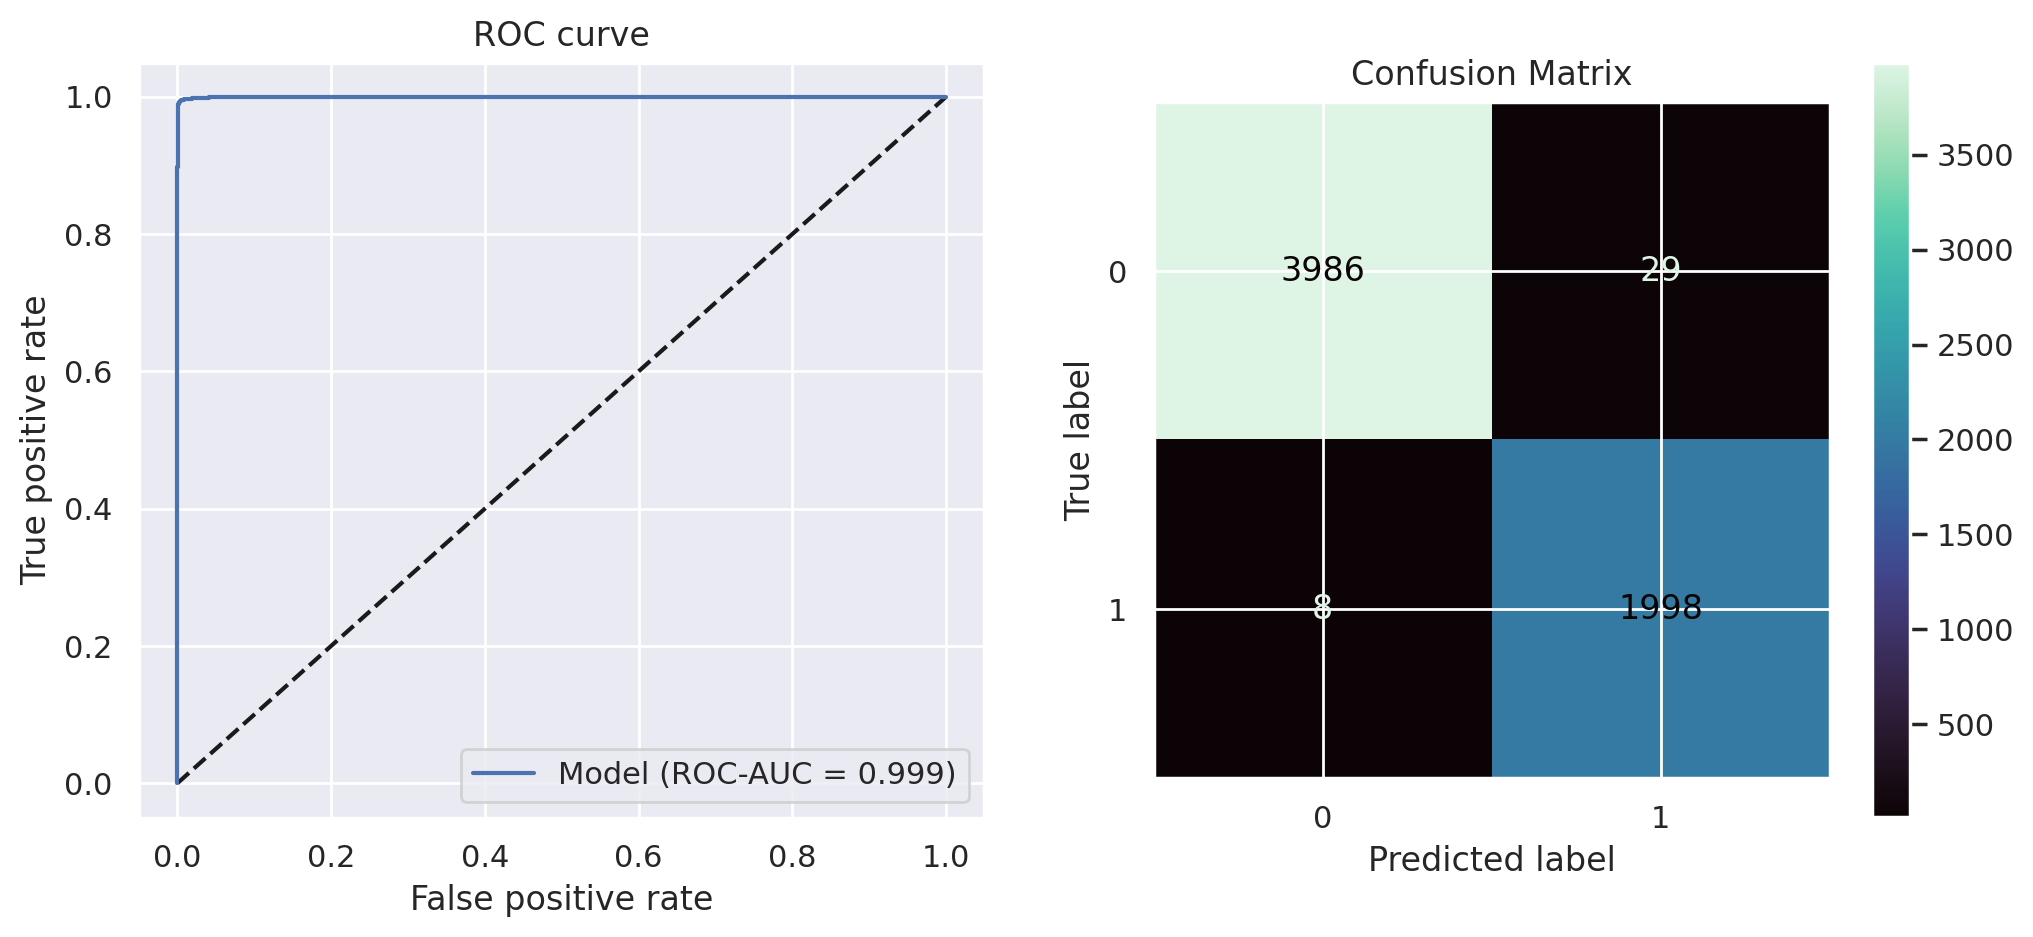

In [23]:
supervised_test.test()